<a href="https://colab.research.google.com/github/GabeMaldonado/JupyterNotebooks/blob/master/VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VECTOR AUTOREGRESSION MODELS (VAR)

We can use VAR models to work with two time series  in order to determine they correlate and/or have any effect on one another.

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline

In [0]:
# import stats models forecasting tools

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

In [0]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## # Load Data and Perform EDA
M2SLMoneyStock and PCEPersonalSpending dataframes.

In [0]:
# Load Moneystock dataset

df1 = pd.read_csv('M2SLMoneyStock.csv', index_col = 0, parse_dates = True)

# Set frequency
df1.index.freq = 'MS'

In [0]:
# Load PCE dataset

df2 = pd.read_csv('PCEPersonalSpending.csv', index_col = 0, parse_dates = True)

# Set freqeuncy
df2.index.freq = 'MS'

In [6]:
# Display df's heads
df1.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [7]:
df2.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [8]:
# Combine both dataframes using join
# assign it to a new df to make changes permanent

df = df1.join(df2)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [9]:
# Get data on df
df.describe()

,Money,Spending
count,252.000000,252.000000
mean,6978.151190,8562.311905
std,2554.325115,2231.933352
min,3489.900000,4850.800000
25%,4732.875000,6682.125000
50%,6507.400000,8777.150000
75%,8699.700000,10262.925000
max,12335.900000,12469.100000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 1995-01-01 to 2015-12-01
Freq: MS
Data columns (total 2 columns):
Money       252 non-null float64
Spending    252 non-null float64
dtypes: float64(2)
memory usage: 15.9 KB


In [11]:
df.shape

(252, 2)

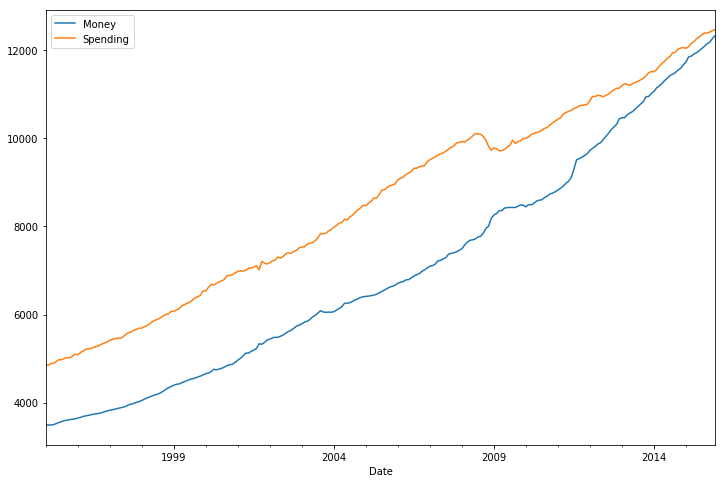

In [12]:
# Visualize Data

df.plot(figsize = (12,8));

### Test Data for Stationary and Perform Transformations

In [0]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [14]:
# run adf on the 'Money' column of dataframe

adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [15]:
# Run adf on the 'Spending' column of dataframe
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [0]:
# Transform data by running a first order differece and creating a new df (df_transform) 

df_transform = df.diff()

In [17]:
df_transform.head()

,Money,Spending
Date,,
1995-01-01,NaN,NaN
1995-02-01,-2.5,-0.4
1995-03-01,1.2,34.6
1995-04-01,8.1,4.8
1995-05-01,25.0,42.9


Run the adf_test on the transform data to check for stationary.

In [18]:
# run adf test on 'Money' column
adf_test(df_transform['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [19]:
# run adf_test on 'Spending' column
adf_test(df_transform['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


The 'Money' column is still non-stationary so we would have to transform it again. When we transform we sacrifice the first row so we can do a 'dropna' to take care of that.

In [0]:
df_transform = df_transform.diff().dropna()

In [21]:
df_transform.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [22]:
# check stationary for 'Money'
adf_test(df_transform['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [23]:
adf_test(df_transform['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Train Test Split
Now that both columns are stationary, we can perform a train, test, split -- using 12 months as a test set so we can later forecast a year into the future. 

In [0]:
# Define number of observations

num_of_obs = 12

In [0]:
train = df_transform[:-num_of_obs]

In [0]:
test = df_transform[-num_of_obs:]

### Perform A Gridsearch for Order p AR of VAR Model
We need to choose the order for the vector auto-regression model. 
Normally we would run Autoarima to get the orders but it doesn't work for Vector Auto Regression.

In [28]:
# Find order of p

model = VAR(train)

for p in [1, 2, 3, 4, 5, 6, 7]: #range(8)
  results = model.fit(p)
  print(f'ORDER {p}')
  print(f'AIC : {results.aic}')
  print('\n')

ORDER 1
AIC : 14.178610495220896


ORDER 2
AIC : 13.955189367163705


ORDER 3
AIC : 13.849518291541038


ORDER 4
AIC : 13.827950574458281


ORDER 5
AIC : 13.78730034460964


ORDER 6
AIC : 13.799076756885809


ORDER 7
AIC : 13.797638727913972




In [0]:
# fit VAR with lowest AIC, 5 in the case above
results = model.fit(5)

In [31]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 20, Jul, 2019
Time:                     13:47:17
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

## Forecasting a Month into the Future

The .foreast option requires the parameters (y, steps) where *steps* is the number of steps ahead (12 in this case) using values *y* . 'Y' needs to be a numpy array of (p x k) where *p* is the actual lag order (L1, L2...) and *k* is the number of time series variables (two in this case for 'Money' & 'Spending') so *y* needs to be a 5x2 numpy array. To get *y* we need to grab 5 lagged values right before the test starts.

In [32]:
# Grab 5 values from train set and create a lagged_values np array

train.values.shape

(238, 2)

In [0]:
lagged_values = train.values[-5:]

In [34]:
train.values[-5:].shape

(5, 2)

In [0]:
# .forecast(y, steps) and asing to z

z = results.forecast(y = lagged_values, steps = 12)

In [39]:
# Convert z into a dataframe
# create datetime index

index = pd.date_range('2015-01-01', periods = 12, freq = 'MS')
index

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [0]:
# create dataframe

df_forecast = pd.DataFrame(data = z, index = index, columns = ['Money_2d', 'Spending_2d'])

In [49]:
df_forecast.head()

,Money_2d,Spending_2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365


### Reversing Differences

The forecasted values were obtained with second order differences. To effectively compare against the original data, we have to reverse the differences. To achieve this, we take the most recent value of the original seried and add it to a cummulative sum of forecasted values. 

In [0]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-num_of_obs-1]-df['Money'].iloc[-num_of_obs-2]) + df_forecast['Money_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-num_of_obs-1] + df_forecast['Money1d'].cumsum()

In [0]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-num_of_obs-1]-df['Spending'].iloc[-num_of_obs-2]) + df_forecast['Spending_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-num_of_obs-1] + df_forecast['Spending1d'].cumsum()

In [53]:
df_forecast.head()

,Money_2d,Spending_2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


### Visualizing Predictions

Plot forecasted values for Money and Spending against the true values in the test set.

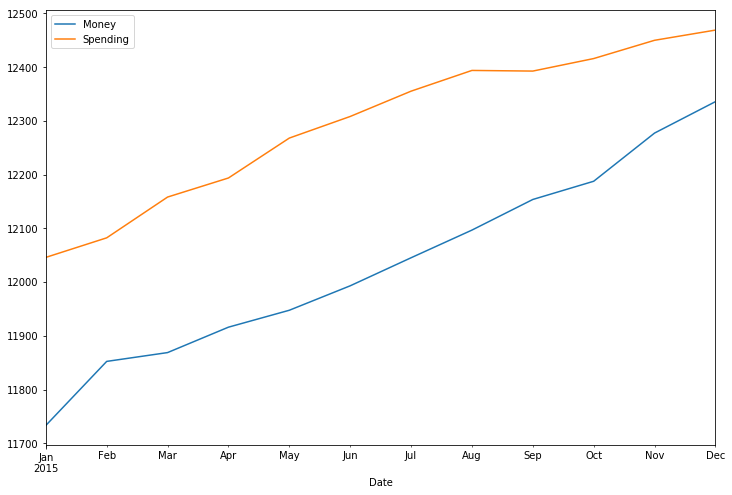

In [55]:
# grab test data from original dataframe
test_range = df[-num_of_obs:]
test_range.plot(figsize = (12,8));

In [56]:
# get forecasted columns to plot
df_forecast.columns

Index(['Money_2d', 'Spending_2d', 'Money1d', 'MoneyForecast', 'Spending1d',
       'SpendingForecast'],
      dtype='object')

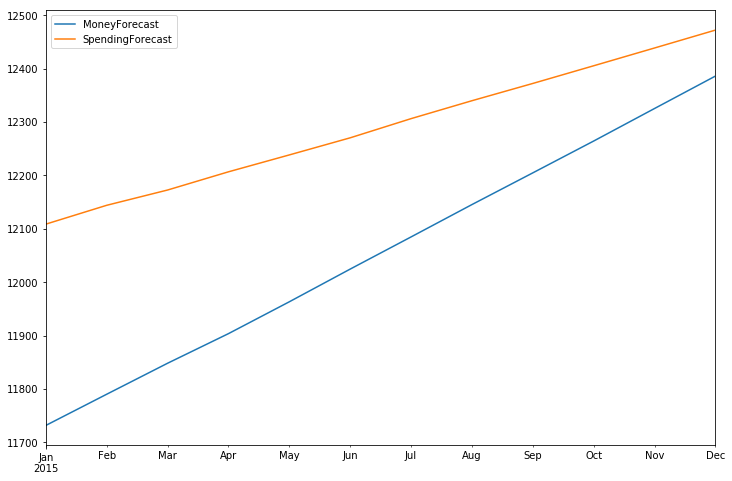

In [57]:
# grab columns of interest nad plot
df_forecast[['MoneyForecast', 'SpendingForecast']].plot(figsize = (12,8));

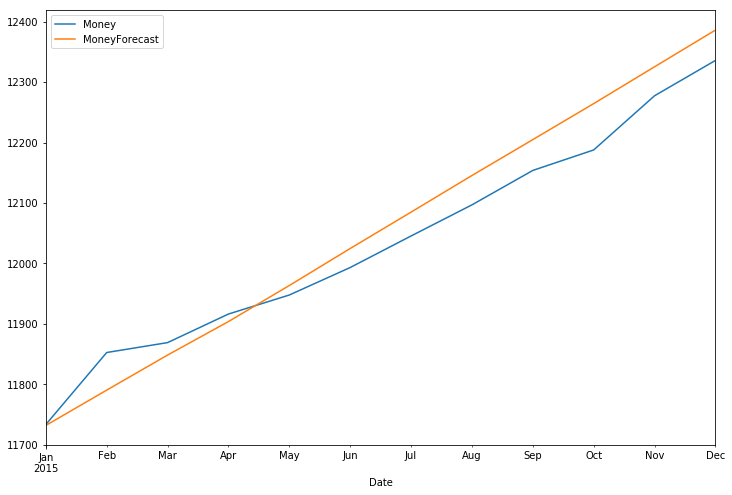

In [58]:
# Plot the variables against each other
# Plot 'Money'
test_range['Money'].plot(figsize = (12, 8), legend = True)
df_forecast['MoneyForecast'].plot(legend = True)

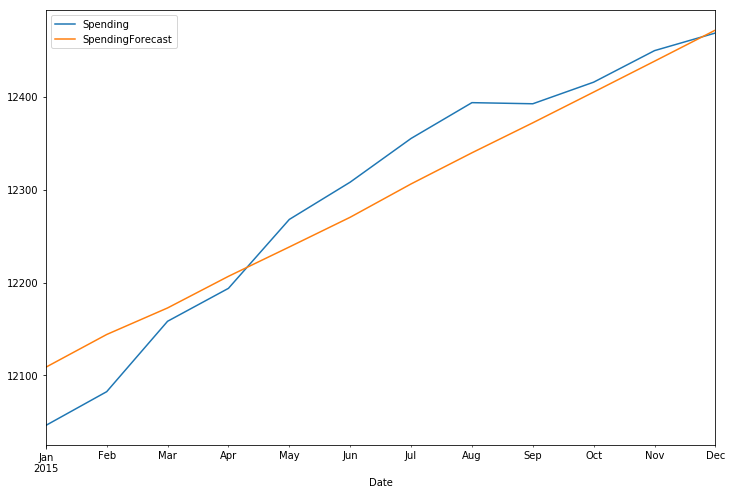

In [59]:
# Plot the variables against each other
# Plot 'Spending'
test_range['Spending'].plot(figsize = (12, 8), legend = True)
df_forecast['SpendingForecast'].plot(legend = True)

### Evaluate Model

Use RMSE to evaluate model

In [60]:
# evaluate money
rmse(test_range['Money'], df_forecast['MoneyForecast'])

43.71049653558893

In [62]:
# evaluate spending
rmse(test_range['Spending'], df_forecast['SpendingForecast'])

37.001175169408285